# Representing strings in pandas

In this notebook we compare the memory required for the different string representations in pandas. Prior to pandas v1, there were _object_ and _category_. The lastest versions of pandas include a dedicated _string_ dtype.

In [1]:
%load_ext autoreload
%autoreload 2

import string
from random import choices, choice
from typing import Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The pandas version we're using (see end of the notebook for details):

In [2]:
print(pd.__version__)

1.1.0


Functions to help creating our benchmark:

In [3]:
def generate_values(length: Union[int, list], distinct: int):
    """Generate a set of random letter combinations of a certain length
    
    :param length: length of the string
    :param distint: number of distinct values
    :return: set of strings
    """
    if isinstance(length, int):
        length = [length]
    
    vals = set()
    while len(vals) < distinct:
        vals.add("".join(choices(string.ascii_letters, k=choice(length))))
    return vals


def get_type_representations():
    """The possible Series representations for the string values
    
    :retrurn: set of strings
    """
    types = {
        "object", 
        "category"
    }
    if hasattr(pd, "StringDtype"):
        types.add("string")
    return types

Up next is the configuration of our benchmark:

In [4]:
n_rows = [100, 1000, 10000, 100000]
distinct_ratio = [0.01, 0.1, 0.2, 0.5, 1.0]

# Fixed length strings
# string_lenghts = 20

# Variable length strings
string_lenghts = list(range(100))

Benchmark by looping over the combinations and tracking the (deep) memory usage:

In [5]:
types = get_type_representations()

series_sizes = []
for n in n_rows:
    for dp in distinct_ratio:
        distinct = int(dp * n)
        distinct_values = list(generate_values(string_lenghts, distinct))
        vals = distinct_values * int(n / distinct)
        for t in types:
            series_sizes.append(
                {
                    "n": n,
                    "distinct_percentage": dp,
                    "size": pd.Series(vals, dtype=t).memory_usage(deep=True, index=True),
                    "dtype": t,
                }
            )

sizes_df = pd.DataFrame(series_sizes)

Plot the results:

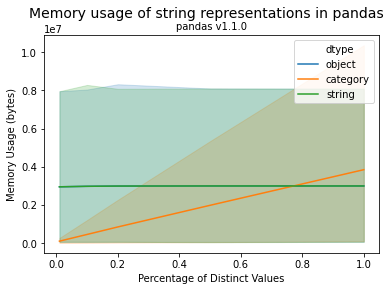

In [6]:
ax = sns.lineplot(x="distinct_percentage", y="size", hue="dtype", data=sizes_df)

plt.ylabel("Memory Usage (bytes)")
plt.xlabel("Percentage of Distinct Values")
plt.suptitle("Memory usage of string representations in pandas", fontsize=14)
plt.title(f"pandas v{pd.__version__}", fontsize=10)
plt.show()

We can see (depending on your version of pandas), that the category's memory usage increases linearly, while that of object/string is more or less constant with respect to the percentage of distinct values. The transparent area's show represent the range of memory usage for different numbers of rows.

The memory usage of the types is close to linear for all representations if we consider the ratio of distinct values. We might use this ratio to determine which representation to use.

In [7]:
def find_point_of_intersection(x="category", y="object", group="distinct_percentage"):
    """
    Find point of intersection between two types
    
    :param x: 
    """
    x = sizes_df[sizes_df['dtype'] == x].groupby(group)['size'].mean()
    a1, a2 = np.polyfit(x.index, x, deg=1)
    y = sizes_df[sizes_df['dtype'] == y].groupby(group)['size'].mean()
    b1, b2 = np.polyfit(y.index, y, deg=1)
    
    poi = (a2 - b2) / (b1 - a1) 
    return poi

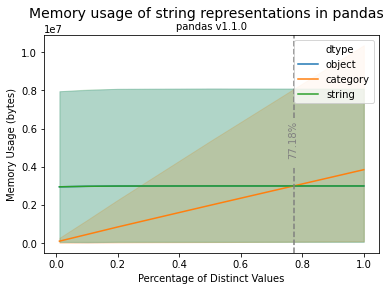

In [8]:
ax = sns.lineplot(x="distinct_percentage", y="size", hue="dtype", data=sizes_df)

b = find_point_of_intersection("category", "object")
plt.axvline(b, 0, 0.40, linestyle='--', color='grey')
plt.axvline(b, 0.62, 1, linestyle='--', color='grey')
plt.text(b, ax.get_ylim()[1] / 2, f"{b:.2%}", rotation=90, verticalalignment='center', horizontalalignment='center', color='grey')

plt.ylabel("Memory Usage (bytes)")
plt.xlabel("Percentage of Distinct Values")
plt.suptitle("Memory usage of string representations in pandas", fontsize=14)
plt.title(f"pandas v{pd.__version__}", fontsize=10)
plt.show()

## Caution with pandas 1.0.0-1.0.5
In versions 1.0.0-1.0.5 it might appear that the "string" representation in pandas has improved significantly in terms of memory consumption. It does not. This is actually a bug in `StringArray.memory_usage()`. See [GH33963](https://github.com/pandas-dev/pandas/issues/33963) for details. The issue was fixed in 1.1.0.

